## 요약
- 추가 전처리
    - `00 형식의 연도를 숫자로 변환
    - 특수문자 '／':'/' 로 변환
    - 저자명에서 '000 외 지음'으로 되어있는 경우 '000 외'
- mecab을 이용한 기본 설정 tokenize
    - 이후 품사를 제한해보는 것도 필요
- padding & integer encoding
    - BName, BName_sub, Category에 적용
    - maxlen은 각각 30,25,5로 ths를 정함

- 이 과정에서 찾은 전처리 오류들은 code/process_bookinfo에 반영 완료
    - 반영된 버전이 0.75

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [4]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
save_dir = 'processed/'
file_name = f'bookinfo_ver0.5.csv'

In [5]:
file_path = os.path.join(PRJCT_PATH,save_dir,file_name)
bookinfo = pd.read_csv(file_path)
bookinfo

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
0,322.0,민병철 생활영어 1,NaN,54947,민병철,False,기타 출판사,1979-10-01,5500,4950,177.0,외국어,2001년1월3주
1,767.0,행복에의 초대,NaN,168173,IVP(한국기독학생회출판부) 편집부,False,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주
2,449.0,훈련으로 되는 제자,NaN,458277,월터 A. 헨릭슨,False,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주
3,490.0,전태일 평전,NaN,128759,조영래,False,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주
4,300.0,제자의 삶,NaN,131488,프랜시스 M.코스그로브,False,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,NaN,342597187,야마다 카네히토,True,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주
9324,138.0,약사의 혼잣말 13,NaN,342597589,네코쿠라게,True,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주
9325,129.0,타몬 군 지금 어느 쪽?! 7,NaN,342597714,시와스 유키,True,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주
9326,209.0,천재 의사 시건방 1,NaN,342388828,강효미,True,기타 출판사,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주


In [20]:
pat = r'\'\d\d(?!\d)'
def detect_pattern(pat,text):
    return re.findall(pat,text)

text = "'070에서 '07까지 '08-'09 "
detect_pattern(pat,text)

["'07", "'08", "'09"]

In [31]:
def change_num2year(text):
    pat = r'\'\d\d(?!\d)'
    temp = sorted([m.start() for m in re.finditer(pat,text)])
    rslt = list(text)
    for i in temp[::-1]:
        t = text[i+1:i+3]
        digit = int(t)
        if digit > 59 : rslt[i] = '19'
        else : rslt[i] = '20'
    return ''.join(rslt)

change_num2year(text) 

"'070에서 2007까지 2008-2009 "

In [50]:
def replace_by_dict(text,chr_dict):
    for key,val in chr_dict.items():
        text = text.replace(key,val)
    return text

special_chr = {
  '&#xFF3C;' : '\\',
  '／':'/',
}

In [52]:
bookinfo['BName'] = bookinfo['BName'].apply(lambda x : replace_by_dict(x,special_chr))
cond = ~bookinfo.BName_sub.isna()
bookinfo.loc[cond,'BName_sub']=bookinfo.loc[cond,'BName_sub'].apply(lambda x : replace_by_dict(x,special_chr))

In [32]:
bookinfo.BName = bookinfo.BName.apply(change_num2year)
cond = ~bookinfo.BName_sub.isna()
bookinfo.loc[cond,'BName_sub']=bookinfo.loc[cond,'BName_sub'].apply(change_num2year)

In [161]:
cond = bookinfo.Author == '박지원 외'
np.sum(cond)

2

In [162]:
bookinfo[cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
1002,435.0,호질.양반전.허생전 외,NaN,261957,박지원 외,True,기타 출판사,2000-12-25,6000,5400,2328.0,소설/시/희곡,2005년2월1주
2020,742.0,우리 고전소설 한마당,NaN,448997,박지원 외,False,기타 출판사,2003-12-17,12000,10800,2681.0,청소년,2011년12월5주


**filtered_240711**
- 780.0,국내도서,달라이 라마 지구의 희망을 말한다,260777,9788989197065,,"텐진 갸초 외 지음, 오정숙 옮김",롱셀러,2000-12-25,8800,7920,440점,94.0,종교/역학,2001년1월3주
- 435.0,국내도서,호질.양반전.허생전 외,261957,9788908032156,4810.0,"박지원 외 지음, 이민수 옮김",범우사,2000-12-25,6000,5400,300점,2328.0,소설/시/희곡,2005년2월1주
- 742.0,국내도서,우리 고전소설 한마당,448997,9788976700476,43810.0,박지원 외 지음,혜문서관,2003-12-17,12000,10800,600점,2681.0,청소년,2011년12월5주
- 177.0,국내도서,노빈손의 으랏차차 중국 대장정,448875,9788958071914,3810.0,"강영숙 외 지음, 이우일 그림",뜨인돌,2003-12-18,9500,8550,470점,7006.0,청소년,2005년2월1주
- 775.0,국내도서,생명 생물의 과학,411741,9788970855165,,"Purves 외 지음, 이광웅 외 옮김",교보문고(교재),2003-12-20,38000,38000,"1,140점",609.0,과학,2005년2월1주

#### 크롤링으로 저자 정보를 가져오게 되면 안 생길 문제지만, 일단 추가 전처리 진행
000 외 


In [163]:
book_author = bookinfo.Author
temp = book_author.str.split(' ').apply(lambda x : x[-1])
cond = temp == '외'
np.sum(cond)

422

In [164]:
book_author[cond]

37      질 들뢰즈 외
41        현진건 외
60        김영길 외
67        민선식 외
117       칼 융 외
         ...   
9184      안일구 외
9191      이재석 외
9272      박현도 외
9296     제이포럼 외
9311      김지용 외
Name: Author, Length: 422, dtype: object

In [165]:
temp = book_author[cond]
temp = temp.str.split(' ').apply(lambda x : ' '.join(x[:-1]))
bookinfo.loc[cond,'Author'] = temp
bookinfo.loc[cond,'Author_mul'] = True

In [166]:
bookinfo.loc[cond,'Author']

37      질 들뢰즈
41        현진건
60        김영길
67        민선식
117       칼 융
        ...  
9184      안일구
9191      이재석
9272      박현도
9296     제이포럼
9311      김지용
Name: Author, Length: 422, dtype: object

000 외 00인 or 000 외 00명 

In [224]:
pat = r'\s\d+[인명]$'
text = '안녕하세 외 인'
detect_pattern(pat,text)

[]

In [226]:
text1 = '안녕하세 외 10인'
text2 = '안녕하세 외 10명'
text3 = '안녕하세 외 2310쌍'
display(detect_pattern(pat,text1))
display(detect_pattern(pat,text2))
display(detect_pattern(pat,text3))

[' 10인']

[' 10명']

[]

In [ ]:
text1 = '안녕하세 외 10인'
text2 = '안녕하세 외 10명'
text3 = '안녕하세 외 2310쌍'
display(detect_pattern(pat,text1) == True)
display(detect_pattern(pat,text2) == True)
display(detect_pattern(pat,text3) == True)

False

False

False

In [ ]:
text1 = '안녕하세 외 10인'
text2 = '안녕하세 외 10명'
text3 = '안녕하세 외 2310쌍'
display('hello' if detect_pattern(pat,text1) else '')
display('hello' if detect_pattern(pat,text2) else '')
display('hello' if detect_pattern(pat,text3) else '')

'hello'

'hello'

''

In [227]:
text1 = '안녕하세 외10인'
text2 = '안녕하세 외 10명 그리고 고양이'
text3 = '안녕하세 외 2310쌍17명'
display(detect_pattern(pat,text1))
display(detect_pattern(pat,text2))
display(detect_pattern(pat,text3))

[]

[]

[]

In [231]:
pat1 = r'\s\d+[인명]$'
pat2 = r'외\s\d+[인명]$'
text1 = '안녕하세 외 10인'
text2 = '안녕하세 외 10명'
text3 = '안녕하세 2310명'
display('hello' if detect_pattern(pat2,text1) else '')
display('hello' if detect_pattern(pat2,text2) else '')
display('hello' if detect_pattern(pat2,text3) else '')

'hello'

'hello'

''

In [232]:
cond1 = bookinfo.Author.apply(lambda x : True if detect_pattern(pat1,x) else False)
cond2 = bookinfo.Author.apply(lambda x : True if detect_pattern(pat2,x) else False)

np.sum(cond1 & (~cond2))

0

In [236]:
temp = bookinfo.Author.apply(lambda x : re.sub(pat1,'',x))
temp[cond1]

bookinfo['Author'] = temp

In [237]:
book_author = bookinfo.Author
temp = book_author.str.split(' ').apply(lambda x : x[-1])
cond = temp == '외'
temp = book_author[cond]
temp = temp.str.split(' ').apply(lambda x : ' '.join(x[:-1]))
bookinfo.loc[cond,'Author'] = temp
bookinfo.loc[cond,'Author_mul'] = True

In [238]:
bookinfo.loc[cond1,'Author']

1544        김호기
3319         강풀
3598        김어준
4664        곽수인
4857        박기혁
5833    클라우스 슈밥
6700        권기선
Name: Author, dtype: object

##### 기타 : 장 자끄 상뻬 글
- 815.0,국내도서,얼굴 빨개지는 아이,194628,9788932902456,3860.0,"장 자끄 상뻬 글 그림, 김호영 옮김",열린책들,1999-05-30,8500,7650,420점,5262.0,에세이,2005년2월1주
- 현재 사이트에는 지은이로 되어있음

In [278]:
cond = bookinfo.Author == '장 자끄 상뻬 글'
bookinfo[cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
284,815.0,얼굴 빨개지는 아이,NaN,194628,장 자끄 상뻬 글,True,열린책들,1999-05-30,8500,7650,5262.0,에세이,2005년2월1주


In [283]:
roles = [
'글', '시', '역', '외',
'제공',
'소설',
'극본',
'강의',
'사진',
'구술',
'정리',
'엮음',
'부록',
'편저',
'감수',
'교열',
'그림',
'역주',
'주해',
'판화',
'지음',
'연출',
'감역',
'서문',
'자문',
'옮김',
'편집',
'평역',
'만화',
'사회',
'추천',
'해제',
'각본',
'저자',
'각색',
'원안',
'역자',
'영역',
'해설',
'구성',
'요리',
'기획',
'원작',
#'머리',
'지도',
'작곡','대담','편곡',
'디자인','스토리','디렉터','풀어씀','총편집','엮고지음',
'옮겨엮음',
'일러스트',
'자원집필',
'책임편집',
'소설구성',
'시나리오',
'글.사진',
'콘티구성',
'편찬책임',
'글.그림',
'글.삽화',
'기획.제작',
'동영상강의',
'엮음.사진',
#'관리위원회',
'기획.채록',
'편집·해설',
'사진.캘리그라피'
]

In [284]:
def extract_author1(content:str):
    ele0 = content.split(',')[0].strip()
    temp = ele0.split(' ')
    if temp[-1] not in roles: return ele0
    else : return ' '.join(temp[:-1])

In [285]:
temp = bookinfo['Author'].apply(extract_author1)
cond = temp == bookinfo.Author
np.sum(~cond)

19

In [286]:
bookinfo[~cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
59,887.0,오행은 뭘까,NaN,107339,전창선.어윤형,False,기타 출판사,1994-06-01,7500,6750,991.0,인문학,2001년1월3주
284,815.0,얼굴 빨개지는 아이,NaN,194628,장 자끄 상뻬 글,True,열린책들,1999-05-30,8500,7650,5262.0,에세이,2005년2월1주
721,450.0,박떡배와 오성과 한음,NaN,251722,박수동 글,False,기타 출판사,2000-10-10,8000,7200,2050.0,만화,2001년1월3주
1864,941.0,신의 나라 인간 나라,NaN,384590,이원복 글,False,기타 출판사,2002-10-28,10000,9000,6881.0,만화,2005년2월1주
2071,928.0,노빈손의 무인도 완전정복,NaN,474160,이우일 글,False,기타 출판사,2004-03-16,13000,11700,2953.0,청소년,2005년2월1주
2272,628.0,국경 없는 마을,NaN,527668,박채란 글,True,기타 출판사,2004-11-20,10900,9810,7082.0,사회과학,2005년2월1주
3231,915.0,유럽에서 꼭 가봐야 할 여행지 100,NaN,11980516,정보상 글,False,기타 출판사,2011-06-17,17800,16020,1825.0,여행,2013년4월4주
3414,174.0,어쿠스틱 라이프 2,NaN,14285791,난다 글,False,기타 출판사,2011-11-26,11500,10350,2598.0,만화,2011년12월5주
3534,469.0,두 번의 결혼식과 한 번의 장례식 Vol. 1,NaN,14300064,박희정 글,True,기타 출판사,2011-12-22,8000,7200,502.0,만화,2011년12월5주
3746,894.0,의사는 수술받지 않는다,NaN,21208170,김현정 글,False,기타 출판사,2012-11-17,15000,13500,1688.0,건강/취미,2013년4월4주


In [287]:
bookinfo.loc[59]

Rank               887.0
BName             오행은 뭘까
BName_sub            NaN
ItemId            107339
Author          전창선.어윤형 
Author_mul         False
Publshr           기타 출판사
Pdate         1994-06-01
RglPrice            7500
SlsPrice            6750
SalesPoint         991.0
Category             인문학
Sorce          2001년1월3주
Name: 59, dtype: object

In [289]:
extract_author1(bookinfo.loc[59,'Author'])

'전창선.어윤형'

In [290]:
temp[~cond]

59      전창선.어윤형
284     장 자끄 상뻬
721         박수동
1864        이원복
2071        이우일
2272        박채란
3231        정보상
3414         난다
3534        박희정
3746        김현정
3758        정다정
3902        네온비
3959        박희정
4087        정다정
4214        박희정
4599         난다
5492         난다
5551         순끼
5604    스에츠구 유키
Name: Author, dtype: object

In [53]:
from konlpy.tag import Mecab
mecab = Mecab()
tokenizer_basic = lambda x : mecab.morphs(x)

# 출처: https://sikaleo.tistory.com/62 [SIKALEO:티스토리]
def tokenizer_kor(raw, pos=["NNG","NNP","VV","VA"]):
    from konlpy.tag import Mecab
    m = Mecab()
    # 길이가 1 이하인 토근은 제외, 위에서 지정한 (mecab 사전에 따른) 토큰들만 특징으로 삼기, 불용어 100개 제외  
    return [word for word, tag in m.pos(raw) if tag in pos]

In [54]:
book_name,book_subname, category = bookinfo.BName, bookinfo.BName_sub, bookinfo.Category
book_name = book_name.apply(tokenizer_basic)
book_subname = book_subname.fillna('').apply(tokenizer_basic)
category = category.apply(tokenizer_basic)

### Integer encoding
- 빈도순으로 정렬하여 가장 많이 나온 token을 1로 시작해서, 양의 정수로 인코딩 
- 길이 통일을 위한 ```'[PAD]'```는 0으로 encoding

In [55]:
import itertools
tokens = np.array(list(itertools.chain(*book_name.values,*book_subname.values,*category.values)))
len(tokens)

84183

In [56]:
corpus = np.unique(tokens,return_counts=True)
display(corpus)
display(len(corpus[0]))

(array(['!', '$', '%', ..., '老子', '漏泄', '六'], dtype='<U14'),
 array([190,   1,  15, ...,   1,   1,   1]))

8541

In [57]:
df_corpus = pd.DataFrame(corpus).T
df_corpus = df_corpus.rename(columns={0:'token',1:'counts'})
df_corpus

,token,counts
0,!,190
1,$,1
2,%,15
3,&,48
4,',24
...,...,...
8536,힙합,2
8537,洛陽,1
8538,老子,1
8539,漏泄,1


- 보통 단어 개수를 32000개쯤 한다는 것 같은데(부정확) 9000개 정도면 크지 않은 것 같음

In [58]:
cond = df_corpus.counts < 2
df_corpus[cond]

,token,counts
1,$,1
16,001,1
18,014,1
20,07,1
21,08,1
...,...,...
8535,힙,1
8537,洛陽,1
8538,老子,1
8539,漏泄,1


In [59]:
targets = [
"／"]
detect_target = lambda x : len(set(x).intersection(set(targets))) > 0
cond = book_name.apply(detect_target)
bookinfo[cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce


In [70]:
temp = df_corpus.sort_values(by='counts',ascending=False)
temp['val'] = np.arange(len(temp))+1
temp = temp.set_index('token')
temp

,counts,val
token,,
/,5608,1
의,2135,2
시,1857,3
소설,1769,4
희곡,1735,5
...,...,...
사이키,1,8537
사이언스,1,8538
사이보그,1,8539


In [86]:
temp2 = temp.to_dict()
map_token_encode = temp2['val']
map_token_encode['[PAD]']=0
map_token_encode

{'/': 1,
 '의': 2,
 '시': 3,
 '소설': 4,
 '희곡': 5,
 '는': 6,
 '만화': 7,
 '(': 8,
 ')': 9,
 '수험서': 10,
 '자격증': 11,
 '1': 12,
 '은': 13,
 '2': 14,
 '인문학': 15,
 '경제': 16,
 '경영': 17,
 '에세이': 18,
 '하': 19,
 '외국어': 20,
 '한': 21,
 '과학': 22,
 '이': 23,
 '자기': 24,
 '을': 25,
 '계발': 26,
 '-': 27,
 ',': 28,
 '3': 29,
 '+': 30,
 '다': 31,
 '사회': 32,
 '권': 33,
 '를': 34,
 '좋': 35,
 '나': 36,
 '가': 37,
 '컴퓨터': 38,
 '기': 39,
 '에': 40,
 '부모': 41,
 '전': 42,
 '종교': 43,
 '역학': 44,
 '.': 45,
 ':': 46,
 '모바일': 47,
 '해': 48,
 '역사': 49,
 '들': 50,
 '청소년': 51,
 '지': 52,
 '고': 53,
 '급': 54,
 '예술': 55,
 '4': 56,
 '건강': 57,
 '문화': 58,
 '대중': 59,
 '커스': 60,
 '영어': 61,
 '기출': 62,
 '과': 63,
 '취미': 64,
 '요리': 65,
 '2016': 66,
 '!': 67,
 '문제집': 68,
 '살림': 69,
 '와': 70,
 '로': 71,
 '능력': 72,
 '5': 73,
 '있': 74,
 '2019': 75,
 '제': 76,
 '토익': 77,
 '일': 78,
 '으로': 79,
 '7': 80,
 '내': 81,
 '읽': 82,
 '세트': 83,
 '실전': 84,
 '게': 85,
 '아이': 86,
 '도': 87,
 '않': 88,
 '말': 89,
 '이야기': 90,
 '만': 91,
 '시험': 92,
 '10': 93,
 '어': 94,
 '편': 95,
 '

### padding & integer encoding

In [118]:
display(book_name.shape)
display(book_name[0])
len_sent = list(map(len,book_name))
display(max(len_sent),min(len_sent))

(9328,)

['민병철', '생활', '영어', '1']

32

1

In [119]:
display(len_sent[np.argmax(len_sent)])
print(book_name[np.argmax(len_sent)])

32

['2022', '최신', '판', '렛', '유인', '공기업', '시험', '전', ',', '실전', '감각', 'UP', '!', '단', '5', '+', '3', '회', '로', '취약점', '정면', '돌파', '!', '국민', '건강보험공단', 'NCS', '봉투', '모의고사', '5', '+', '3', '회']


In [123]:
np.sum(np.array(len_sent) >= 30)

1

<Axes: ylabel='Count'>

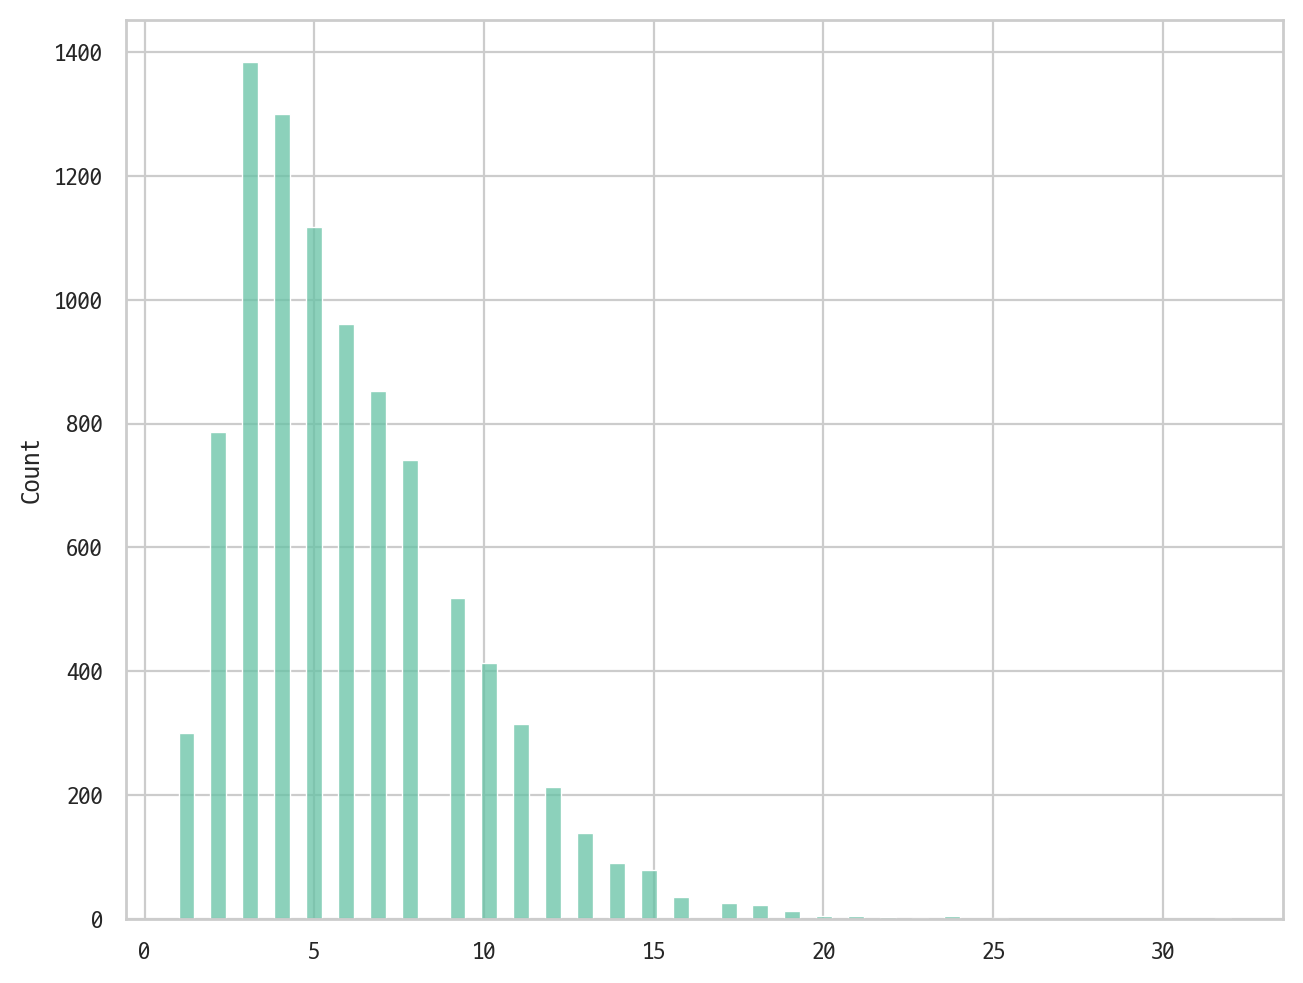

In [110]:
sns.histplot(len_sent)

In [112]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_bookname = pad_sequences(book_name,padding='post',maxlen=30,value='[PAD]',dtype=object)
display(padded_bookname.shape)
padded_bookname

(9328, 30)

array([['민병철', '생활', '영어', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['행복', '에', '의', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['훈련', '으로', '되', ..., '[PAD]', '[PAD]', '[PAD]'],
       ...,
       ['타', '몬', '군', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['천재', '의', '사', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['전지', '적', '루이', ..., '[PAD]', '[PAD]', '[PAD]']], dtype=object)

In [113]:
encode_tokens = lambda x: list(map(lambda y : map_token_encode[y],x))
encoded_bookname = np.apply_along_axis(encode_tokens,0,padded_bookname)
encoded_bookname

array([[8075,  353,   61, ...,    0,    0,    0],
       [ 219,   40,    2, ...,    0,    0,    0],
       [ 925,   79,  124, ...,    0,    0,    0],
       ...,
       [1147, 2270,  406, ...,    0,    0,    0],
       [ 496,    2,  148, ...,    0,    0,    0],
       [1193,  102, 5880, ...,    0,    0,    0]])

In [124]:
len_sent = list(map(len,book_subname))
max(len_sent),min(len_sent)

(44, 0)

<Axes: ylabel='Count'>

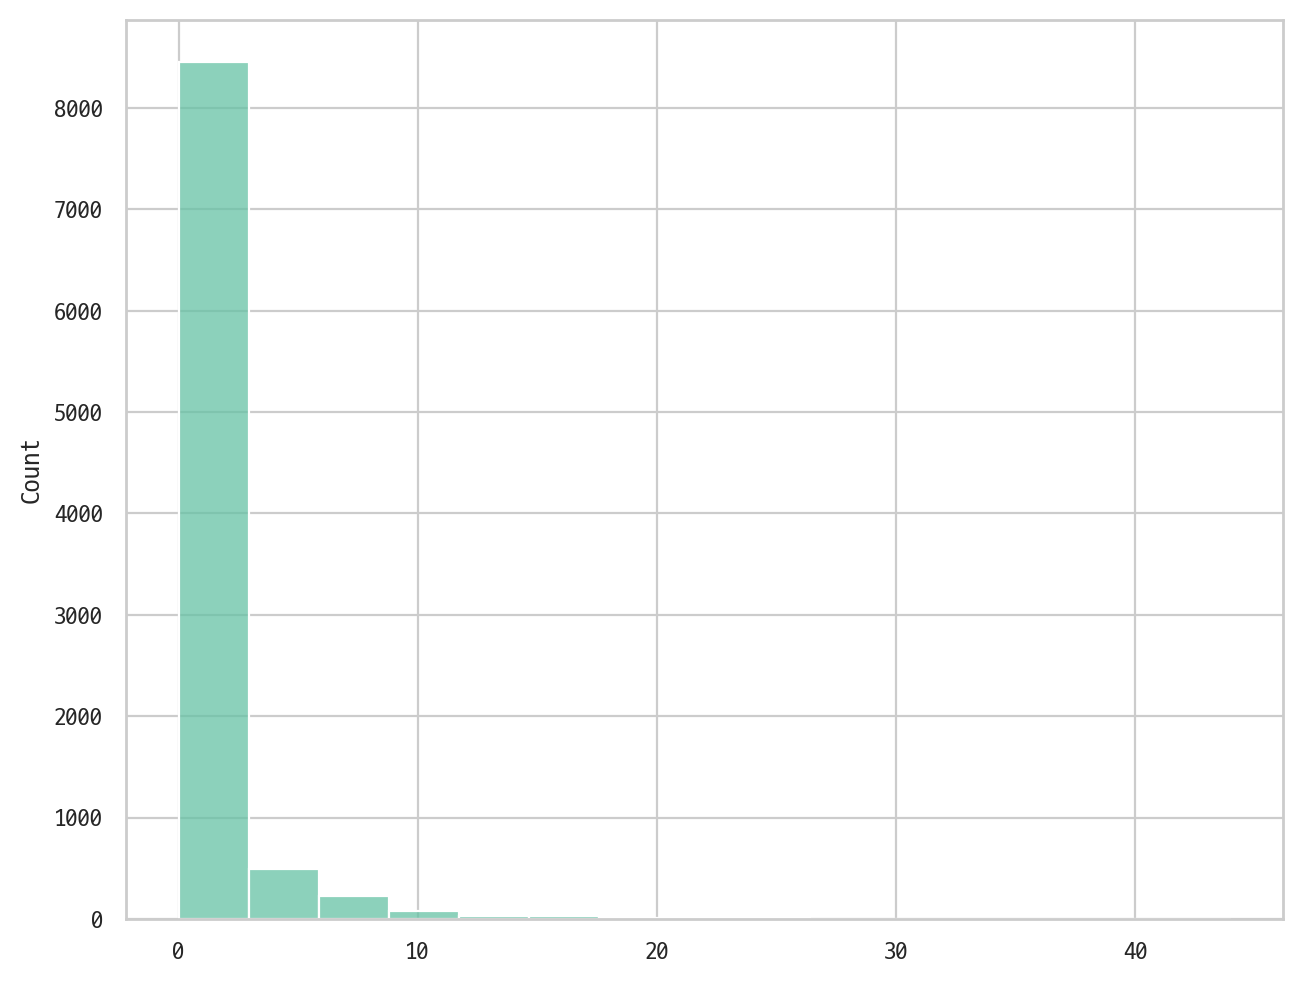

In [116]:
sns.histplot(len_sent)

In [ ]:
display(len_sent[np.argmax(len_sent)])
print(book_subname[np.argmax(len_sent)])

44

['(', '캐릭터', '책갈피', '1', '종', '+', '투명', '포토', '카드', '2', '종', '+', 'DIY', '편지지', '책자', '+', '컵', '홀더', '2', '종', '+', '테이블', '매트', '(', '패브릭', '포스터', ')', '+', '종이', '코스터', '2', '종', '+', '주접', '대사', '스티커', '3', '종', '+', '박스', '포함', '한', '정판', ')']


In [127]:
display(np.sum(np.array(len_sent) >= 20))
display(np.sum(np.array(len_sent) >= 25))
display(np.sum(np.array(len_sent) >= 30))

21

5

3

In [129]:
cond = (np.array(len_sent) > 25)
book_subname[cond]

2836    [(, 테이프, 별매, ), (, Hackers, TOEIC, Listening, ...
3226    [(, 교재, (, ETS, X, -, File, 빈출, 표현, 수록, ), +, ...
4815    [(, 국가, 직무, 능력, 표준, ), 직업, 기초, 능력, 평가, +, 직무, ...
5895    [(, 본, 책, +, 예문, 듣, 기, MP, 3, 파일, 무료, 다운, 로드, ...
8513    [(, 캐릭터, 책갈피, 1, 종, +, 투명, 포토, 카드, 2, 종, +, DI...
Name: BName_sub, dtype: object

In [130]:
padded_subname = pad_sequences(book_subname,padding='post',maxlen=25,value='[PAD]',dtype=object)
encoded_subname = np.apply_along_axis(encode_tokens,0,padded_subname)
encoded_subname

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  8, 957,   9, ...,   0,   0,   0]])

In [131]:
len_sent = list(map(len,category))
max(len_sent),min(len_sent)

(5, 1)

In [132]:
display(len_sent[np.argmax(len_sent)])
display(category[np.argmax(len_sent)])

5

['소설', '/', '시', '/', '희곡']

<Axes: ylabel='Count'>

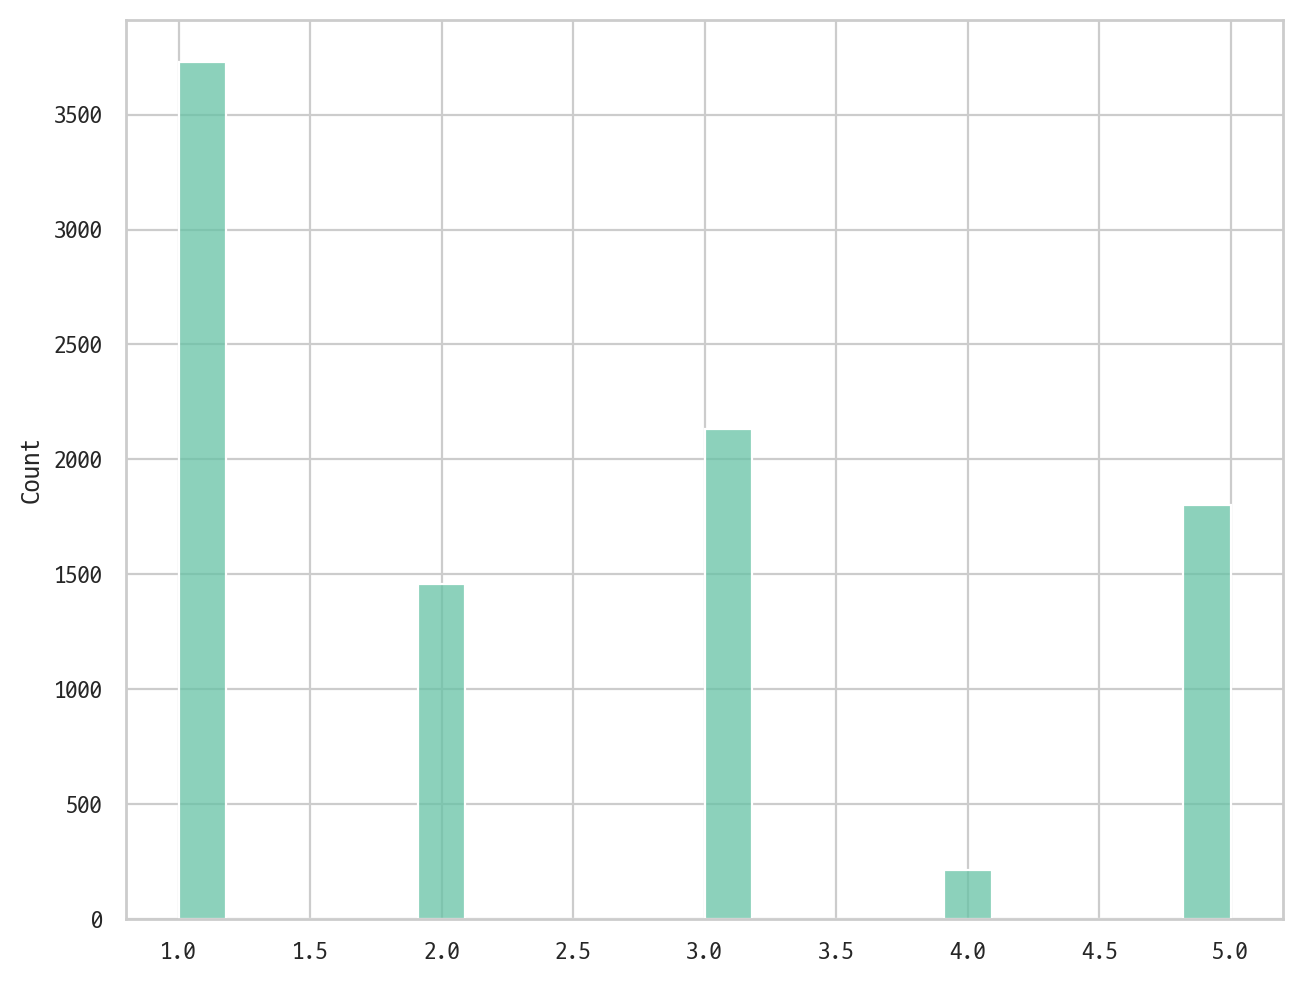

In [133]:
sns.histplot(len_sent)

In [134]:
padded_category = pad_sequences(category,padding='post',maxlen=5,value='[PAD]',dtype=object)
encoded_category = np.apply_along_axis(encode_tokens,0,padded_category)
encoded_category

array([[ 20,   0,   0,   0,   0],
       [ 43,   1,  44,   0,   0],
       [ 43,   1,  44,   0,   0],
       ...,
       [  7,   0,   0,   0,   0],
       [133,   0,   0,   0,   0],
       [ 18,   0,   0,   0,   0]])

#### publshr, author encoding
- publshr는 k = 50 기준으로 전처리 했었음
- author에 대해서도 파악 필요

In [239]:
authors = bookinfo.Author
counts = authors.value_counts()
counts

Author
데이빗 조 (David Cho)    49
길벗 R&D               43
ETS                  37
이동기                  37
해커스어학연구소             36
                     ..
초(정솔)                 1
구수환                   1
남충희                   1
요시다 타로                1
시와스 유키                1
Name: count, Length: 5555, dtype: int64

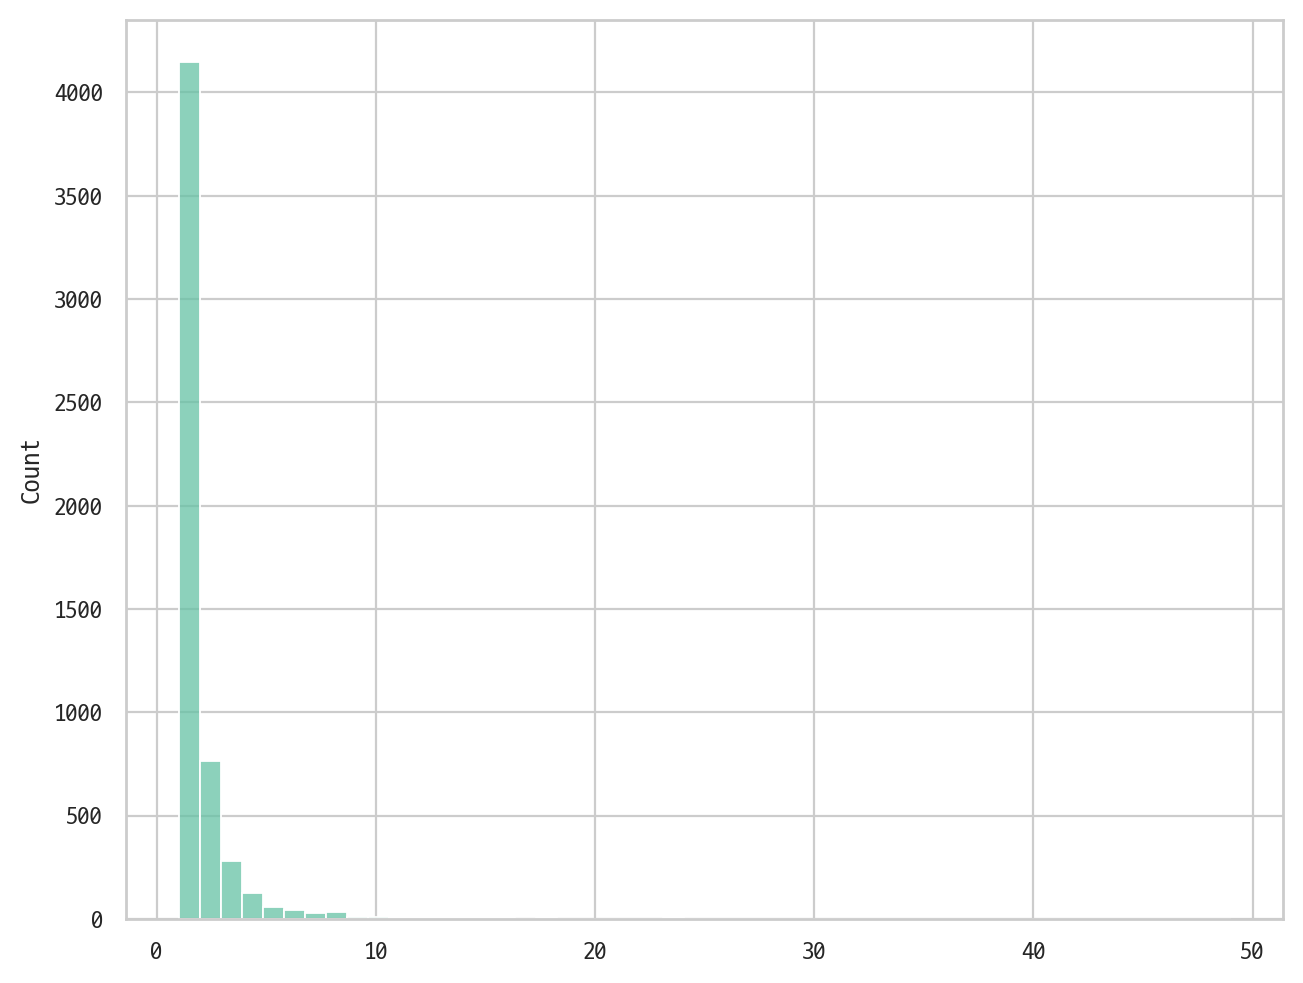

In [240]:
sns.histplot(counts.values,bins=50);

In [241]:
cond = counts >= 2
counts[cond]

Author
데이빗 조 (David Cho)    49
길벗 R&D               43
ETS                  37
이동기                  37
해커스어학연구소             36
                     ..
문학수                   2
고은정                   2
키네코 시바이               2
존 윌리엄스                2
박서련                   2
Name: count, Length: 1410, dtype: int64

In [242]:
cond = counts == 2
counts[cond]

Author
일본보그사        2
스타니스와프 렘     2
서대중          2
백수린          2
혼Job취업연구소    2
            ..
문학수          2
고은정          2
키네코 시바이      2
존 윌리엄스       2
박서련          2
Name: count, Length: 764, dtype: int64

**만약 SalesPoint를 반영한다면?**

In [243]:
pvtb = pd.pivot_table(data=bookinfo,index='Author',values='SalesPoint',aggfunc=np.sum)
pvtb = pvtb.sort_values(by='SalesPoint',ascending=False)
pvtb

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
윤재근,21.0
정영택,20.0
생명의삶,17.0


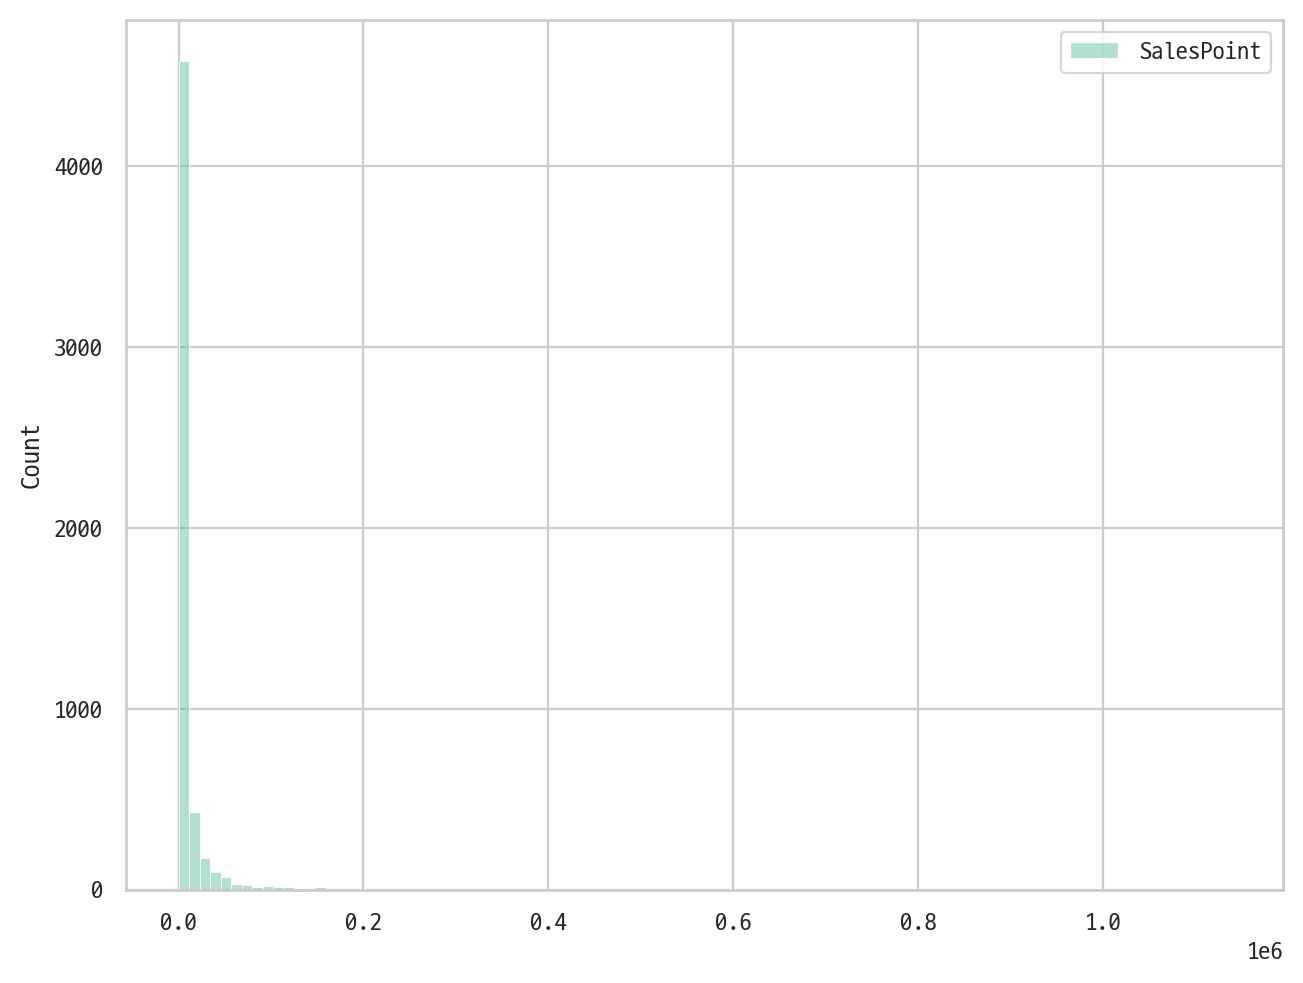

In [244]:
sns.histplot(pvtb,bins=100);

In [245]:
cond = pvtb['SalesPoint'] >= 10000
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
NCS 정보처리기술사 연구회,10105.0
러셀 로버츠,10102.0
김도윤,10061.0


In [246]:
cond = pvtb['SalesPoint'] >= 5000 
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
장문정,5019.0
미셸 오바마,5017.0
이해수,5014.0


In [247]:
cond = pvtb['SalesPoint'] >= 3000 
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
스톤뮤직엔터테인먼트,3018.0
진경혜,3016.0
이찬수,3012.0


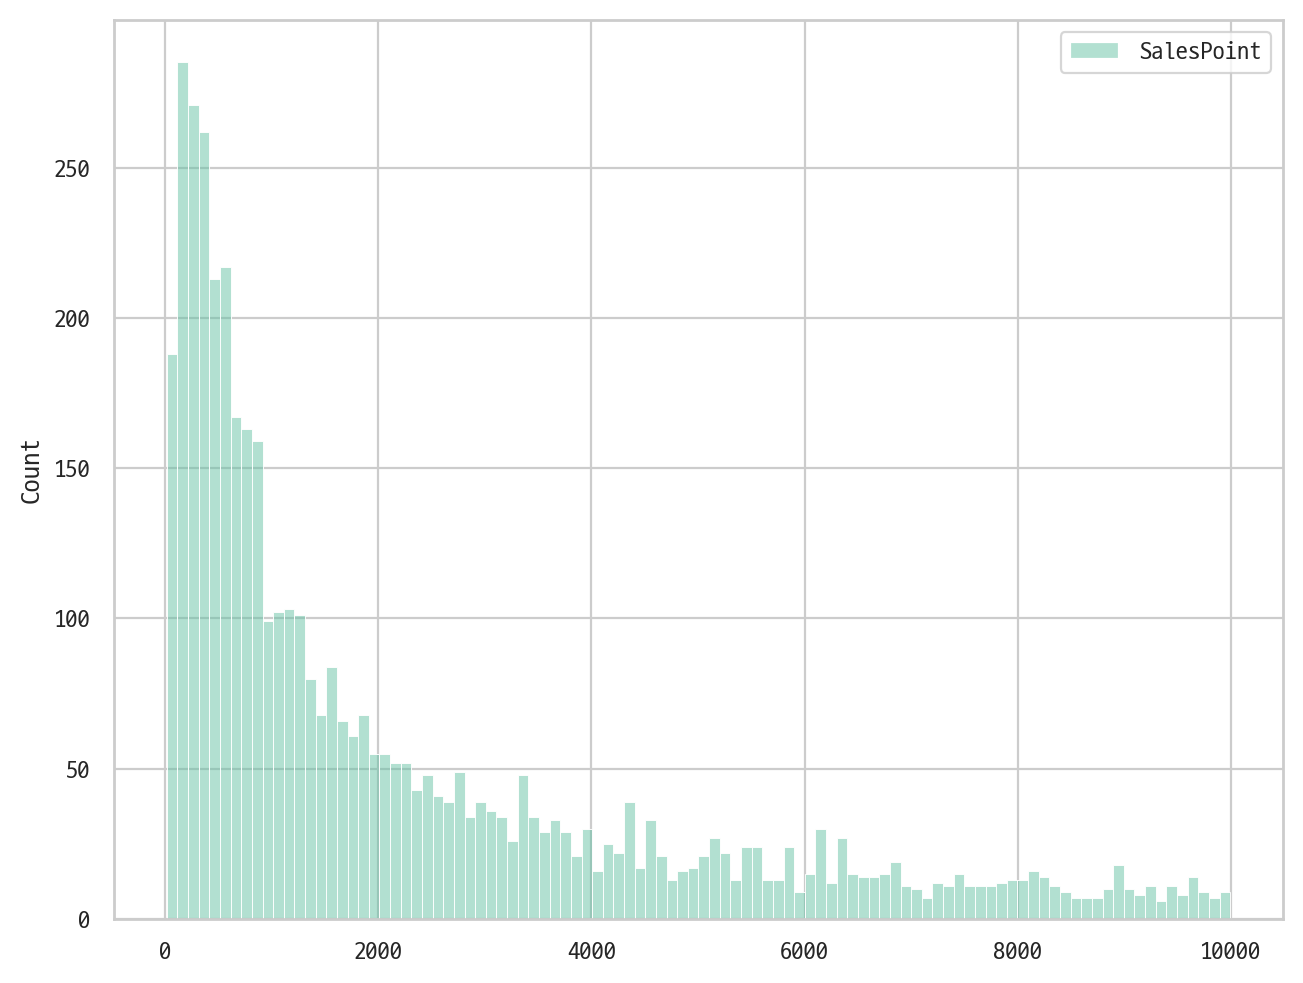

In [248]:
cond = pvtb['SalesPoint'] < 10000
temp = pvtb[cond]
sns.histplot(temp,bins=100);

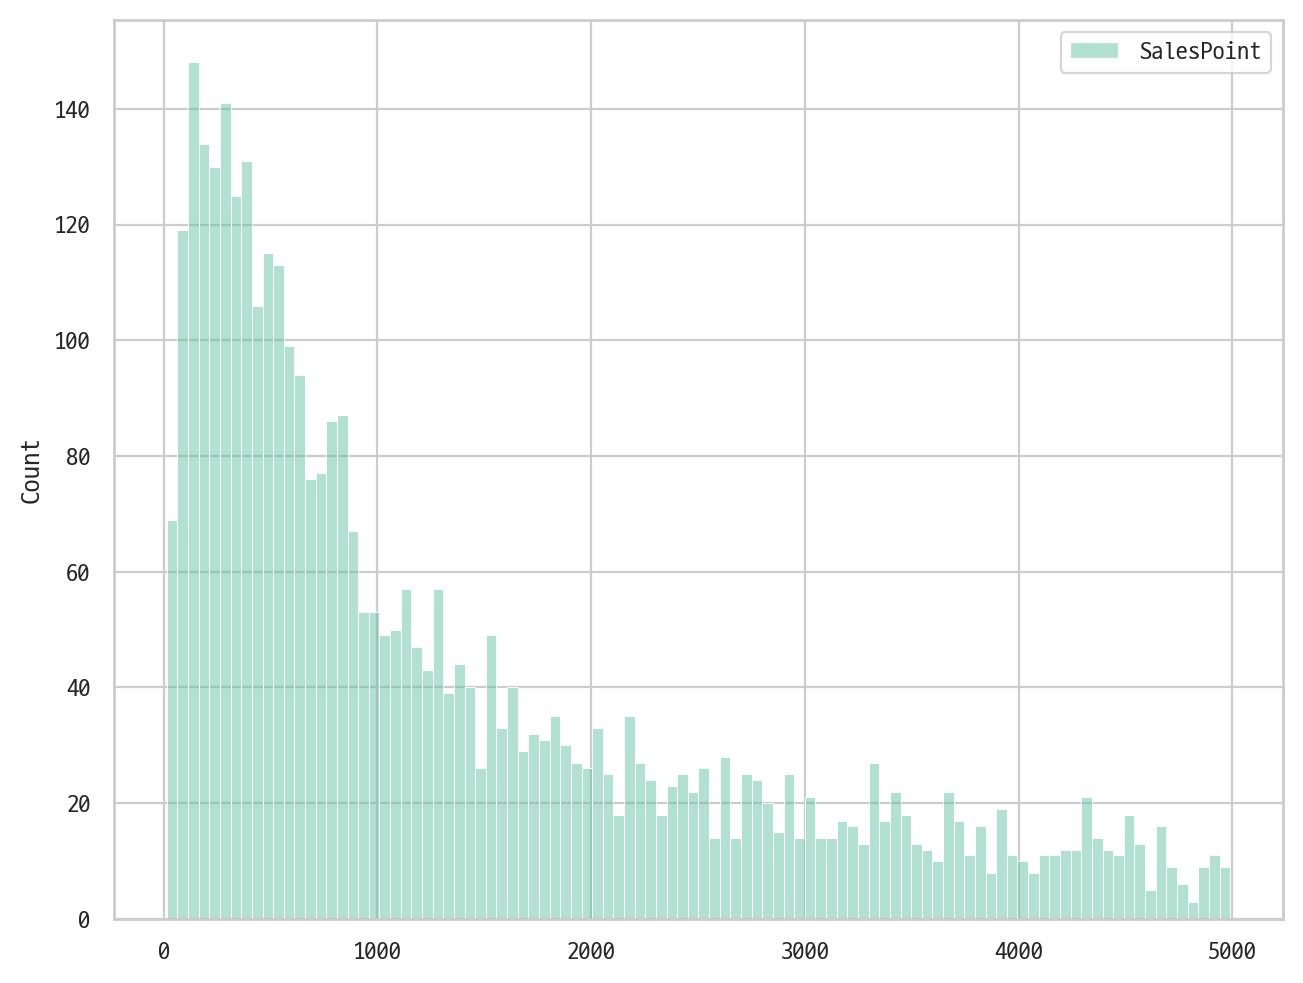

In [249]:
cond = pvtb['SalesPoint'] < 5000
temp = pvtb[cond]
sns.histplot(temp,bins=100);

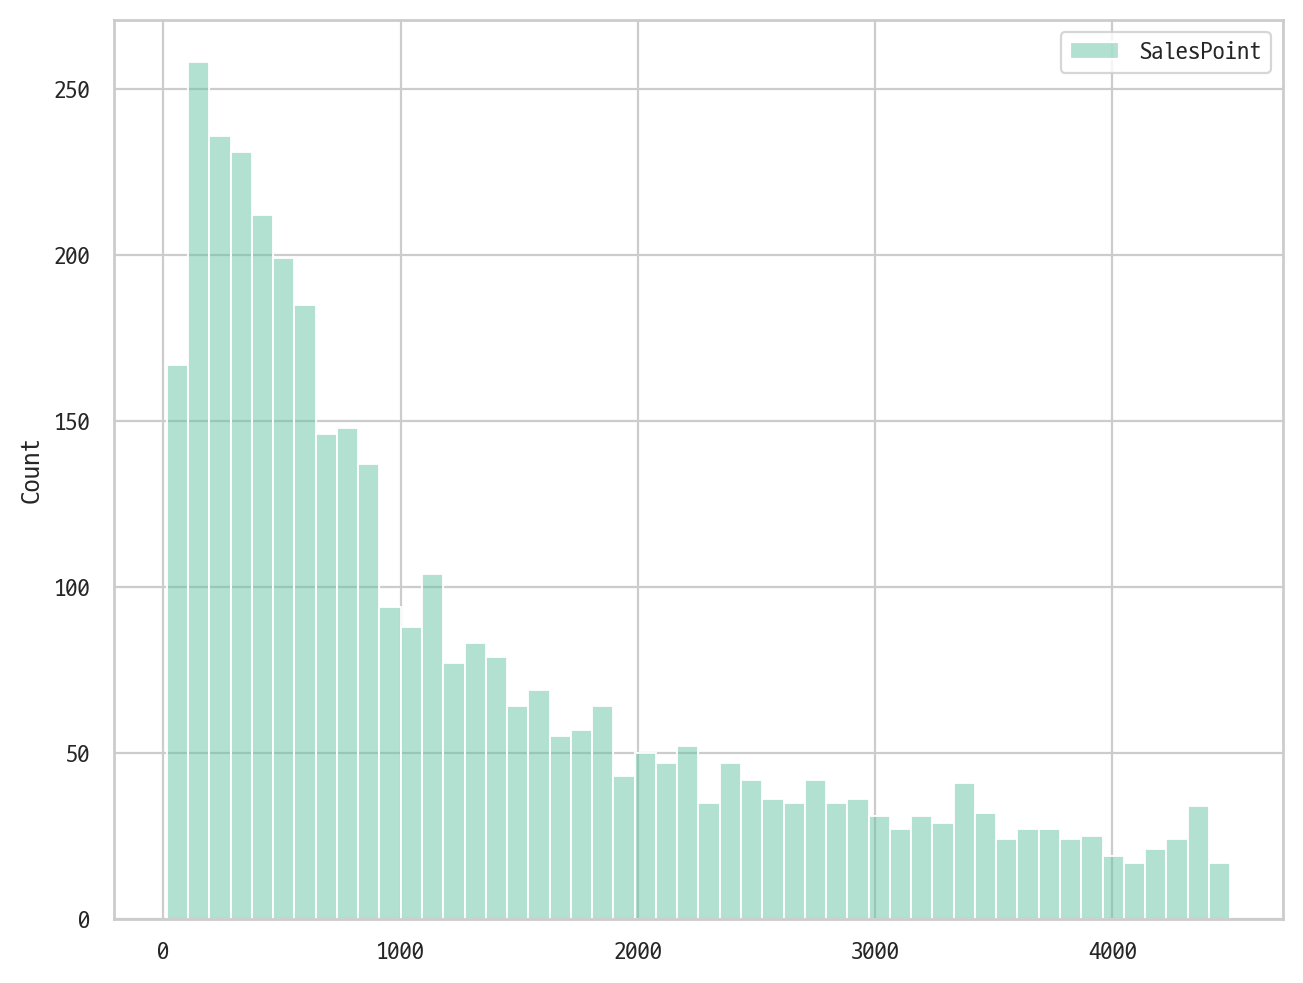

In [250]:
cond = pvtb['SalesPoint'] < 4500
temp = pvtb[cond]
sns.histplot(temp,bins=50);

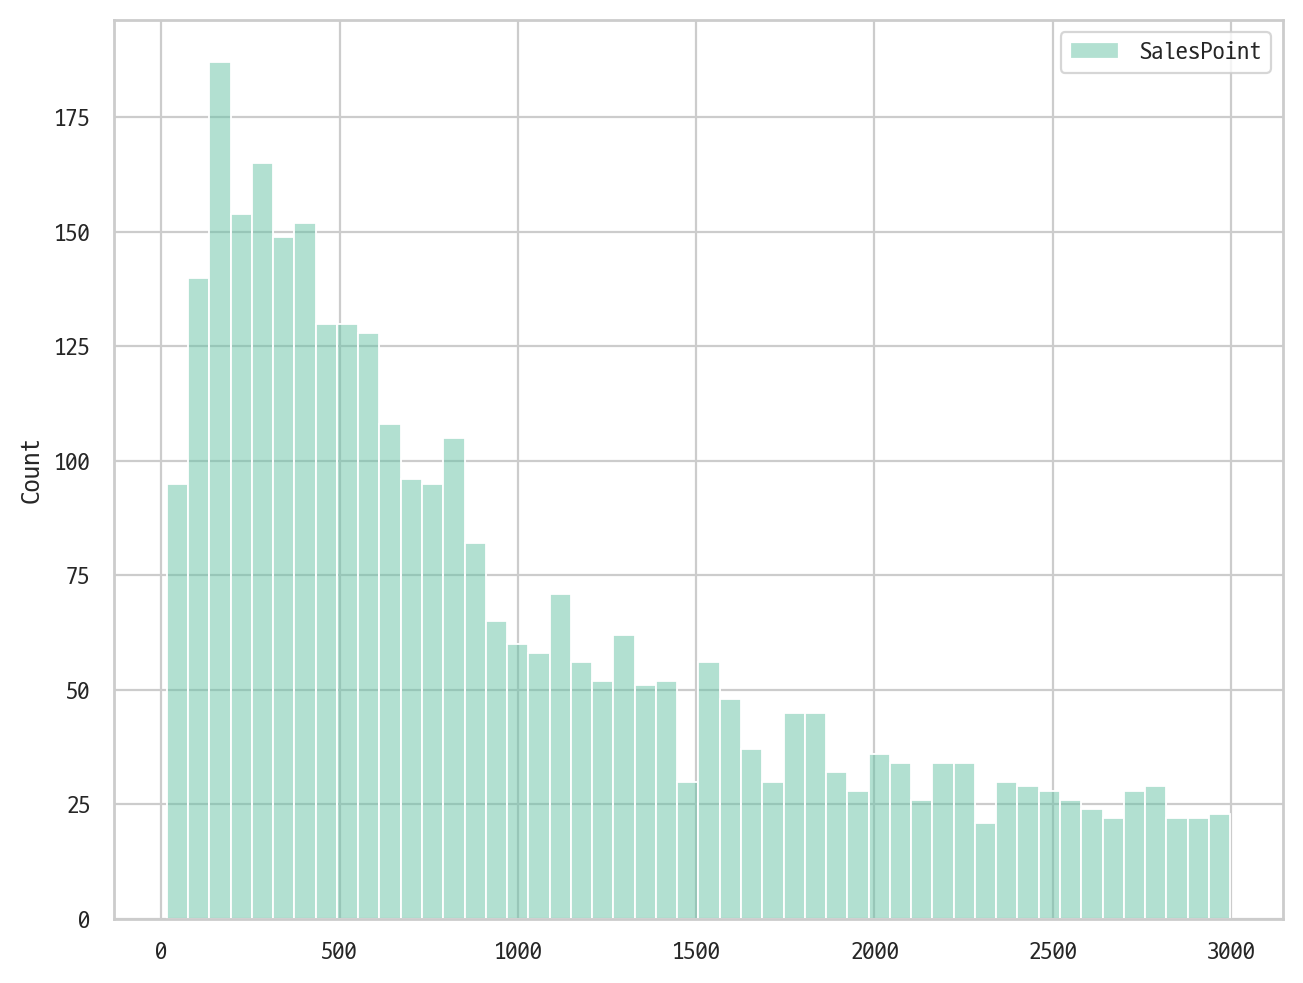

In [251]:
cond = pvtb['SalesPoint'] < 3000
temp = pvtb[cond]
sns.histplot(temp,bins=50);

In [252]:
cond = pvtb['SalesPoint'] >= 2500 
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
엘리자베스 짐머만,2504.0
마사 피퍼. 윌리엄 피퍼,2503.0
함윤미.문혜진,2503.0


In [257]:
author_top_slspnt= pvtb[pvtb['SalesPoint']>=1000].index
author_top_slspnt

Index(['ETS', 'David Cho', '데이빗 조 (David Cho)', '유시민', '최태성', '세이노(SayNo)',
       '무라카미 하루키', '해커스어학연구소', '히가시노 게이고', '김호연',
       ...
       '아카시 칵카쿠', '앤드루 스탠턴', '마이클 브린', '니토리 고이치', '홍민지', 'KBS <생로병사의 비밀> 제작팀',
       '소정현', '두산동아 편집부', '죠 키이코', '원보람'],
      dtype='object', name='Author', length=3542)

In [258]:
author_top_cnt= counts[counts>=2].index
author_top_cnt

Index(['데이빗 조 (David Cho)', '길벗 R&D', 'ETS', '이동기', '해커스어학연구소', 'David Cho',
       '베르나르 베르베르', '전한길', '조정래', '최태성',
       ...
       '타코', '박태균', '해커스JLPT연구소', '김용석', '한일', '문학수', '고은정', '키네코 시바이',
       '존 윌리엄스', '박서련'],
      dtype='object', name='Author', length=1410)

In [264]:
temp = (set(author_top_cnt).difference(set(author_top_slspnt)))
display(len(temp))
display(temp)
display('김대중' in temp)

128

{'FUNA',
 'KEN',
 'SD적성검사연구소',
 'T&T교육교재개발팀',
 '강도운',
 '강영숙.박수정',
 '강효백',
 '고은정',
 '고종훈.신승욱',
 '곽동언',
 '구효서',
 '권지현',
 '김성혜',
 '김세영',
 '김송은.에듀플렉스 교육개발연구소',
 '김영준.김병태',
 '김용석',
 '김유향',
 '김지하',
 '김진구',
 '나츠미즈 리츠',
 '나카노 교코',
 '나카무라 하지메',
 '냔냐',
 '노가원',
 '니시 케이코',
 '다나카 요시키',
 '다카하시 루미코',
 '디모데 편집부',
 '레이 몽크',
 '로즈빈',
 '루스 보든',
 '류재현',
 '류향',
 '리무코로',
 '마르시아스 심',
 '마순자',
 '마에카와 유타카',
 '마이클 크라이튼',
 '메이비',
 '모리모토 슈',
 '모리하시 빙고',
 '문시현',
 '문언희',
 '발락',
 '배재민',
 '법조문연구회',
 '생명의말씀사 편집부',
 '성혜림',
 '손석춘',
 '손에스더',
 '송재정',
 '스즈키 히사시',
 '시사상식편집부',
 '시사영어사 편집부',
 '신일숙',
 '실천민속학회',
 '심우철.박진우',
 '아라키 신',
 '아오이 세키나',
 '아카마츠 켄',
 '아카필로 편집부',
 '아키야마 미즈히토',
 '안창현',
 '애덤 잭슨',
 '앨런 폴섬',
 '야마모토 아리',
 '야스다 스즈히토',
 '에듀스 인재개발원',
 '에듀윌 교육출판연구소',
 '에듀윌 상식연구소',
 '엘리자베트 루디네스코',
 '영진교재개발팀',
 '오바 츠쿠미',
 '오사카 미에코',
 '오우기 유즈하',
 '오자와 유키',
 '옥한흠',
 '윈글리쉬닷컴',
 '윌리엄 리스트 히트문',
 '유도주',
 '유미즈루 이즈루',
 '유연',
 '유우키 마사미',
 '유호철',
 '이동숙',
 '이와이 슌지',
 '이육사',
 '이자와 모토히코',
 '이정우',
 '이진욱',
 '이태종',
 '장재혁',
 '장정일',
 '잭 캔필드',
 '전국민주노동조

False

In [274]:
temp = (set(author_top_slspnt).difference(set(author_top_cnt)))
display(len(temp))
display(temp)
display('김대중' in temp)

2260

{'황철곤',
 '앙드레 베르제.드 니 위스망',
 'BLW 연구소',
 '우노 다카시',
 '문지웅',
 '네비게이토 편집부',
 '윤선현',
 '(주)아이비즈넷',
 '김현근',
 '장 자끄 상뻬 글',
 '로버트 기요사키 & 샤론 레흐트',
 '이유명호',
 '마이클 길모어',
 '김점선',
 '오비디우스',
 '조르조 바사니',
 '오키타 미즈호',
 '김옥남.송재현',
 '석지영',
 '제현주',
 '편혜영',
 '피터 마운트 샤스타',
 '최태성.장종근',
 '존 브라이트',
 '김명호',
 '크리스티네 뇌스트링거',
 '박경숙',
 '이하나',
 '앤소니 버제스',
 '장재화',
 '전우용',
 '백온유',
 '얀 케르쇼트',
 '손철주.이주은',
 '차민진(밍찌)',
 '대커 켈트너',
 '우에타니 부부',
 '고화정',
 '허진희',
 '이창수',
 '오현웅',
 '키노 씨네필 편집부',
 '진실의 힘 세월호 기록팀',
 '김그래',
 '서이레',
 '스티븐 크보스키',
 '한화순',
 '심상정',
 '임홍택',
 '크리스티나 순톤밧',
 '레일 라운즈',
 '정병열',
 'Michael A. Putlack & e-Creative Contents',
 '이해수',
 '천장팅',
 '이유리',
 '호시노 미즈키',
 '조혜진',
 '이종구',
 '이선미',
 '네이선 퍼.수재너 하몬 퍼',
 '이븐 알렉산더',
 '성철.법정',
 '린다 유',
 '김리연',
 '쿠켄 편집부',
 '서울대학교 TEPS',
 '베네딕트 앤더슨',
 '장하성',
 '최윤식',
 '이원지',
 '황윤권',
 '임민찬',
 '문성희',
 'JRC 중국어연구소',
 '세이카 료겐',
 '이병관',
 '성정아',
 '케빈 켈리',
 '미셸 오바마',
 '미셸 자우너',
 '강헌',
 '최희수.신영일',
 '권다현',
 '최승욱',
 '리디아 데이비스',
 '임용옥',
 '에쿠니 가오리.쓰지 히토나리',
 '강금주',
 '박은봉',
 '하이케 팔러',
 '존 보글',
 '돈복

False

In [273]:
display('김대중' in author_top_slspnt)
display('기타 저자' in author_top_slspnt)

True

False